In [444]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyproj as proj
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from sklearn.cluster import DBSCAN
import geopandas as gpd
import folium
import branca
%matplotlib inline

### Outline
1. Brief exploration/cleaning of data
2. Selection of data points collected during typical working hours
3. Selection of device IDs with the most data points falling within a radius of WeWork Chelsea
4. Clustering of all data points collecting during typical working hours for these IDs
5. Ideas on improvements, further analysis, and other ways to approach these tasks

### 1.

In [445]:
data = pd.read_csv('chelsea_gps_pt1_lim1000.csv')

In [446]:
data.head()

,safegraph_id,latitude,longitude,horizontal_accuracy,utc_timestamp_int,utc_timestamp,geo_hash
0,80d145884625726d8bce56df7b306fab92a8e9fcd675e8...,40.739563,-74.001310,21.601000,1505070624,2017-09-10 15:10:24-04,dr5ru03vh
1,4599f31fc3e32320780c6d3917e6d449a40780fcb54d1e...,40.757786,-73.985287,19.275999,1505176709,2017-09-11 20:38:29-04,dr5ru7tx3
2,4599f31fc3e32320780c6d3917e6d449a40780fcb54d1e...,40.610453,-73.981775,21.417999,1505101556,2017-09-10 23:45:56-04,dr5rh8bj5
3,4599f31fc3e32320780c6d3917e6d449a40780fcb54d1e...,40.753622,-73.984369,20.870001,1505166797,2017-09-11 17:53:17-04,dr5ru6ypp
4,4599f31fc3e32320780c6d3917e6d449a40780fcb54d1e...,40.611249,-73.980564,26.400000,1505001644,2017-09-09 20:00:44-04,dr5rh90cx


In [447]:
print 'Dataset has ' + str(len(data)) + ' rows'

Dataset has 1011222 rows


In [448]:
print 'Dataset has ' + str(len(data.safegraph_id.unique())) + ' unique IDs'

Dataset has 1000 unique IDs


In [449]:
obs_counts = data.groupby('safegraph_id').size()
obs_counts.head(10)

safegraph_id
000c776996daa9b426f414656ad33d80f950b3561d794e0657e1f1d4133076e6     557
001f59cf7e1b0425bd022bc962fc67a231eea9acf9f20ae3a7c80ace37836b83     429
00b9b1593d1b06082fed4ebd6ddeac3f8ec241ea5a8d6b0f469ef672dfdcfa7e    3169
00d96147f99877f84aa90e53aca0300c1e3dfd655fcd7d7b4f9ff3ffddf0487b       7
0140fad111a717c15cc4d2060e636e32284d498aee236de1e5ea9f6da3838f75      93
01c0efb38f576d43d8dcde22490469c76fb7be648d11afec2d2de2b46318271d     255
01c6e5892161b66c57401c2e2d864ce39380b376ebdccb0b87d8e8df2754b153    5295
0213798c9a3828754573bc23e5957da9f7fd8b33f05552ebd995615cef599157     517
02360c61a2899effca6ac2902ec631e8d863137c6624505a837b44f5b0ea0004     456
02e08218cbf2a26eca51ca713629fbe874837b77757fb5bce9b1cb9905547c27     750
dtype: int64

In [450]:
print 'Max observations for a single ID: ' + str(obs_counts.max())
print 'Min observations for a single ID: ' + str(obs_counts.min())

Max observations for a single ID: 39959
Min observations for a single ID: 1


Different device IDs have very different numbers of observations in the dataset. This is relevant for future timeseries analysis and clustering of "moving" point data. 

In [451]:
obs_counts.mean()

1011.222

In [452]:
# trim data to IDs with over 200 observations
ids = obs_counts[obs_counts > 200].index
data = data[data.safegraph_id.isin(ids)]

In [453]:
print 'Dataset now has ' + str(len(data)) + ' rows'

Dataset now has 973462 rows


In [454]:
# timestamp to pandas datetime object
data['datetime'] = pd.to_datetime(data.utc_timestamp)

In [455]:
# date range
data.datetime.min(), data.datetime.max()

(Timestamp('2017-09-09 00:00:00'), Timestamp('2017-09-15 23:59:59'))

Sample plotting of the record with the most observations.

In [456]:
max_id = obs_counts[obs_counts == 39959].index[0]
max_device = data[data.safegraph_id == max_id]

(-74.026075295698931,
 -73.709934704301077,
 40.565947581309786,
 40.905332418690207)

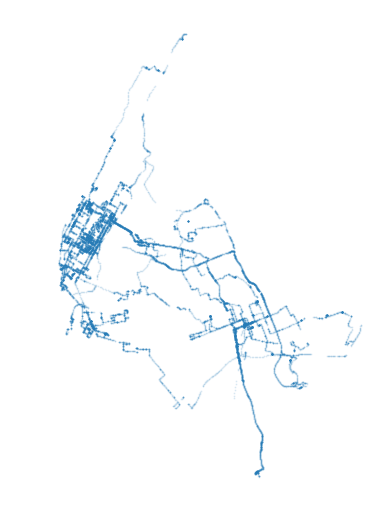

In [457]:
plt.figure(figsize=(6, 9))
plt.scatter(x=max_device.longitude.values, y=max_device.latitude.values, s=1, alpha=.1)
plt.axis('off')

This particular ID appears to be doing a lot of driving around...

### 2.

In [458]:
# code each record by day of the week and hour of the day
data['dayofweek'] = data.datetime.apply(lambda x: x.dayofweek)
data['hourofday'] = data.datetime.apply(lambda x: x.hour)

In [459]:
# select just the weekday records to look at worker patterns
weekday = data[data.dayofweek < 5]

# only approximate working hours
workhours = weekday[(weekday.hourofday > 7) & (weekday.hourofday < 18)]

### 3.

In [460]:
crs_wgs = proj.Proj(init='epsg:4326')
crs_ny = proj.Proj(init='epsg:26918') # use a locally appropriate projected CRS, with units in meters

x, y = proj.transform(crs_wgs, crs_ny, -73.9980658, 40.7402629)
wework = Point(x,y)

In [461]:
# get 160m radius around WeWork
radius_buffer = wework.buffer(160)

In [462]:
# project each observation's lat/lon
proj_coords = [proj.transform(crs_wgs, crs_ny, x, y) for x, y in zip(workhours.longitude, workhours.latitude)]
proj_points = [Point(xy) for xy in proj_coords]

In [463]:
# set geometry column to the projected points
workhours['geometry'] = proj_points

/Users/ianstuart/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [464]:
radius_mask = workhours.geometry.apply(lambda x: x.within(radius_buffer))
print 'Number of observations within the radius: ' + str(radius_mask.sum())

Number of observations within the radius: 804


(-74.002125420862711,
 -73.993993579137282,
 40.736816019453812,
 40.743660980546181)

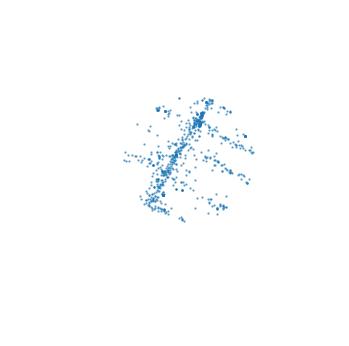

In [465]:
plt.figure(figsize=(5, 5.5))
plt.scatter(x=workhours.longitude.values[radius_mask], y=workhours.latitude.values[radius_mask], s=2, alpha=.5)
plt.axis('off')

In [466]:
obs_counts = workhours[radius_mask].groupby('safegraph_id').size()
obs_counts.mean()

4.6473988439306355

In [467]:
# number of IDs with over 10 observations in WeWork area during working hours
len(obs_counts[obs_counts > 9])

18

In [468]:
# select just those IDs
data0 = workhours[workhours.safegraph_id.isin(obs_counts[obs_counts > 9].index)]

(-74.026147044289189,
 -73.709862955710804,
 40.565898481832996,
 40.905381518167005)

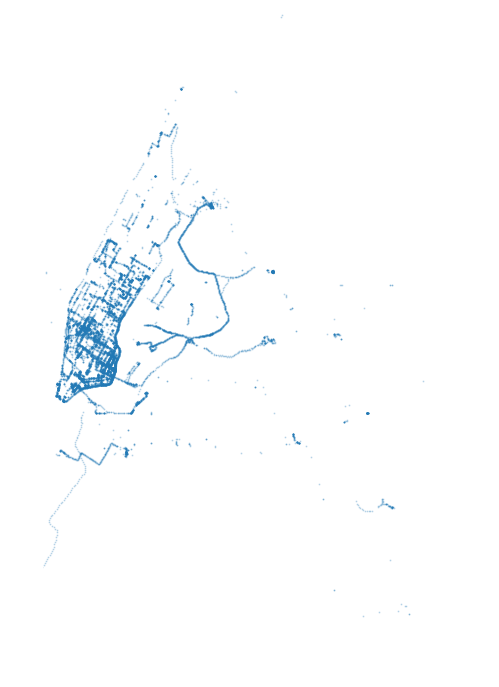

In [469]:
# plot those IDs
plt.figure(figsize=(8, 12))
plt.scatter(x=data0.longitude.values, y=data0.latitude.values, s=1, alpha=.2)
plt.xlim([-74.026147044289189,-73.709862955710804])
plt.ylim([40.565898481832996,40.905381518167005])
plt.axis('off')

### 4.

In [470]:
# get coordinates as numpy array, for clustering
coords = data0[['longitude', 'latitude']].as_matrix()

In [471]:
# DBSCAN clustering
kms_per_radian = 6371.0088
epsilon = .02 / kms_per_radian # using 20m as maximum distance between two points in a cluster

# minimum 40 points in a cluster
db = DBSCAN(eps=epsilon, min_samples=40, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 45


In [472]:
def get_centroid(cluster):
    centroid = Point([MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y])
    return centroid

centroids = clusters[:-1].map(get_centroid) # last "cluster" has zero points
centroids_gdf = gpd.GeoDataFrame({'geometry': centroids})

In [473]:
boros = gpd.read_file('Borough Boundaries/geo_export_5d96a341-d886-490b-9130-e2fde4f386cc.shp')

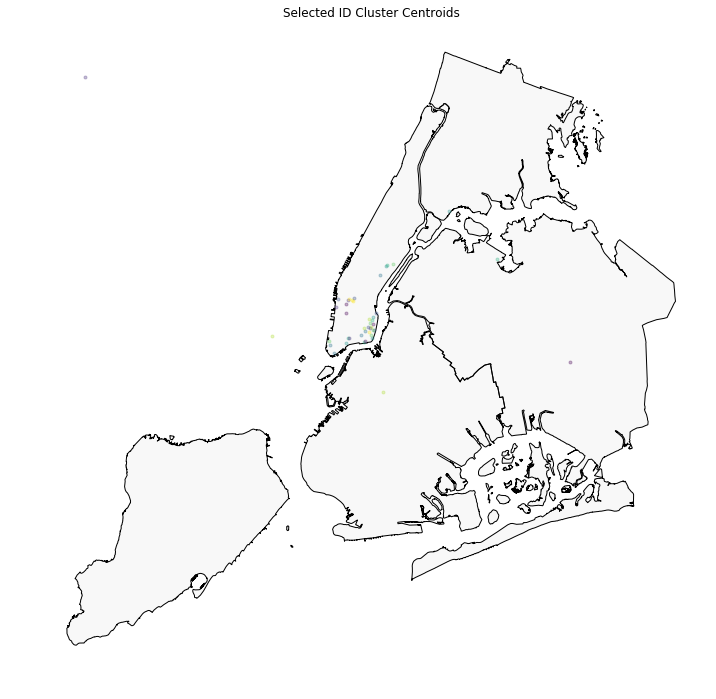

In [474]:
fig, ax = plt.subplots(1, figsize=(12,12))
base = boros.plot(ax=ax, color='#dedede', lw=0.2, alpha=0.2)

centroids_gdf.plot(ax=base, marker="o", markersize=3, alpha=0.3)

_ = ax.axis('off')

ax.set_title('Selected ID Cluster Centroids')

In [476]:
# Folium plot of cluster centroids

def plotPoint(point):
    folium.CircleMarker(location=[point.y, point.x], radius=7, weight=0, fill_color='red', fill_opacity=0.5).add_to(m)

m = folium.Map(location=[40.7402629, -73.9980658],
           tiles='cartodbpositron',
           zoom_start=12)

centroids_gdf.geometry.apply(plotPoint)

m

The East Village appears to have a high concentration of data points during the weekdays for these IDs.

Image for viewing in github:
![alt text](folium_map.png)

### 5.

#### Notes

The accuracy of these data points seems somewhat limited based on the `horizontal_accuracy` column, and further analysis should likely take this into account.

Observations within the WeWork area during working hours are actually fairly limited, with only 18 of 1000 IDs having 10 or more data points for the entire week. Using a larger portion of the dataset could allow us to identify people who are more likely to work in the area.

Much of the work being done here, including the DBSCAN clustering, could be done using a PostGIS database, which may in fact be a cleaner and faster way to accomplish some of these tasks. 

The plots shown here are very simple and have limited utility. Given more time, I would develop more detailed interactive plots, either within the notebook using Folium or another plotting package, with Tableau or similar visualization software, or in the browser with Javascript.

#### Potential further analyses

The clustering is performed to see where the densest groupings of observations are for those IDs that show up most frequently in the WeWork area. With more time, I would run the algorithm multiple times using different parameters to evaluate which distance thresholds and cluster sizes give results that best capture the natural clustering of the data. These results give an idea of where the individuals spend time during the workday.

The next step would be to look at the same IDs, but for nights and weekends, to get an idea of where this group of people spends time during possible "off" hours. 

Finally, of real interest here is how individuals (particularly those who might work at or near a WeWork location) move over time, or throughout the week. Doing some form of time series clustering (perhaps using dynamic time warping as discussed [here](http://www.sciencedirect.com/science/article/pii/S0952197614003078)) could help identify groups of individuals with similar weekly patterns, and lead to a set of characteristic patterns that could be useful for WeWork's real estate planning.